# The Newton-Raphson method

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def output_matrix(matrix, name):
    display(Markdown(f'$\\mathbf{{{name}}} ='
                     + f'{sp.latex(sp.Matrix(np.round(matrix, 6)))}$'))

When finding stationary points, we are finding roots of the $n$-variable system of $n$ non-linear equations $\nabla f(\mathbf{x}) = 0$, so we can apply any of the methods described in Unit 6. Here we use the Newton–Raphson method for this purpose, which for the system of $n$ non-linear equations $\mathbf{h}(\mathbf{x}) = 0$ uses the iteration formula:

$$
\tilde{\mathbf{x}} = \mathbf{x} - \mathbf{J}^{-1}(\mathbf{x}) \mathbf{h}(\mathbf{x})
$$

where $\mathbf{J}$ is the Jacobian matrix for $\mathbf{h}$.

We have written $\mathbf{h}$ as the vector function here so that we can then substitute $\mathbf{h}(\mathbf{x}) = \nabla f(\mathbf{x})$, which we now do to obtain:

$$
\tilde{\mathbf{x}} = \mathbf{x} - \mathbf{H}^{-1}(\mathbf{x}) \nabla f(\mathbf{x})\tag{6}
$$

where $\mathbf{H}$ is the Jacobian matrix for $\nabla f(\mathbf{x})$, or, equivalently, it is the Hessian matrix of $f(\mathbf{x})$. This is the iteration formula of the Newton–Raphson method.

NOTE: The matrix $\mathbf{H}(\mathbf{x})$ that occurs here is symmetric, which will not in general be the case in a Newton–Raphson iteration formula.

This enables us to use $\mathbf{LDL}^{\text{T}}$ decomposition to solve eqn (6). Whilst we are solving this equation we can also use the $\mathbf{LDL}^{\text{T}}$ decomposition to check that the Hessian matrix is positive definite (as it should be near a local minimum). This is included in the following summary of the Newton–Raphson method.

----
&nbsp;
### Procedure 4 - Newton–Raphson Method

To find a local minimiser for a smooth function $f$ of several variables by the Newton–Raphson method, proceed as follows:

1. Determine a starting vector $\mathbf{x}$.
2. Find the $\mathbf{LDL}^{\text{T}}$ decomposition of $\mathbf{H}(\mathbf{x})$, the Hessian matrix for $f$.
   If $\mathbf{H}(\mathbf{x})$ is not positive definite, then abandon the process.
   If it is positive definite, use the decomposition to find the displacement vector $\mathbf{d}$ by solving the equation:

$$
\mathbf{H}(\mathbf{x}) \, \mathbf{d} = -\nabla f(\mathbf{x})
$$

3. If the iteration has not converged, then replace $\mathbf{x}$ by $\mathbf{x} + \mathbf{d}$ and repeat from step 2.

---



For smooth functions, the Newton–Raphson method converges quadratically provided that the starting value is sufficiently close to the minimiser (assuming exact arithmetic).
That is, eventually we have:

$$
\|\tilde{\mathbf{x}} - \boldsymbol{\alpha}\| \approx C \|\mathbf{x} - \boldsymbol{\alpha}\|^2
$$

for some constant $C$. The proof of this fact is similar to the one-dimensional case described in Unit 1.

For quadratic functions, the Newton–Raphson method locates a local minimiser exactly in one iteration (assuming there are no rounding errors).
A general quadratic function $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^{\text{T}} \mathbf{A} \mathbf{x} + \mathbf{a}^{\text{T}} \mathbf{x} + c$ has a stationary point at $-\mathbf{A}^{-1} \mathbf{a}$.
The gradient vector of this function is $\mathbf{A} \mathbf{x} + \mathbf{a}$ and its Hessian matrix is $\mathbf{A}$.
So the equation in step 2 of the Newton–Raphson method becomes $\mathbf{A} \mathbf{d} = -(\mathbf{A} \mathbf{x} + \mathbf{a})$.
Solving this gives $\mathbf{d} = -\mathbf{x} - \mathbf{A}^{-1} \mathbf{a}$ and hence:

$$
\tilde{\mathbf{x}} = \mathbf{x} + \mathbf{d} = -\mathbf{A}^{-1} \mathbf{a},
$$

which is the stationary point.

---

The Newton–Raphson method is a good method for finding local minima, because of its quadratic convergence, but it does have four drawbacks:

1. The sequence of iterates may not converge to a local minimiser if $\mathbf{x}$ is not sufficiently close to it.

2. At each iteration we need $n$ function evaluations for the vector $\nabla f$ and $\frac{1}{2} n (n + 1)$ function evaluations for the symmetric matrix $\mathbf{H}$, which can be time-consuming when $n$ is large.

3. Each iteration requires the solution of a system of $n$ linear equations to calculate $\mathbf{d}$, which can be time-consuming when $n$ is large.

4. It may happen that $f$ has a local minimiser but $\mathbf{H}(\mathbf{x})$ is not positive definite simply because $\mathbf{x}$ is not close enough to it. The method fails to find the minimiser in such a case.

The next subsection looks at a way of overcoming the first and fourth of these drawbacks, and the final subsection describes a method to overcome the other two.

----
&nbsp;
## Python Implementation
Newton-Raphson iteration formula,
$$
\tilde{\mathbf{x}} = \mathbf{x} - \mathbf{H}^{-1}(\mathbf{x}) \ \nabla f(\mathbf{x})\tag{6}
$$

In [2]:
from numpy.linalg import norm
from Procedures.ldl_decomposition import ldl_decomposition, ldl_solve

In [3]:
def compute_grad_hessian(f, variables, verbose=True):
    """
    Computes symbolic gradient and Hessian matrix of a given Sympy function.

    Parameters
    ----------
    f : sympy.Expr
        The function whose gradient and Hessian we want.
    variables : list of sympy.Symbol
        The variables with respect to which we differentiate.
    verbose : bool, optional
        If True, print the symbolic gradient and Hessian.

    Returns
    -------
    gradient : sympy.Matrix
        The symbolic gradient (column vector).
    Hessian : sympy.Matrix
        The symbolic Hessian matrix.
    """
    gradient = sp.Matrix([sp.diff(f, var) for var in variables])
    if verbose:
        print("Gradient:")
        display(gradient)

    Hessian = sp.Matrix([
        [sp.diff(f, var1, var2) for var2 in variables]
        for var1 in variables
    ])

    if verbose:
        print("\nHessian")
        display(Hessian)
        print()

    return gradient, Hessian

In [4]:
def newton_raphson(f, x0, variables, epsilon=0.5e-5, delta=0.5e-5, eta=0.5e-5,
                   maxiter=100, verbose=False):
    """
    Minimize a scalar function f(x) using the Newton-Raphson method.

    Parameters
    ----------
    f : sympy.Expr
        The scalar function to be minimized. Should be a function of
        the variables in `variables`.
    x0 : array_like
        The initial guess for the minimizer (e.g., [x0, y0, ...]).
    variables : list of sympy.Symbol
        The variables (in order) for f.
    epsilon : float, optional
        Convergence tolerance on the norm of the step: ||x_{k+1} - x_k||.
    delta : float, optional
        Convergence tolerance on the absolute change in function values:
        |f(x_{k+1}) - f(x_k)|.
    eta : float, optional
        Convergence tolerance on the norm of the gradient: ||∇f(x_k)||.
    maxiter : int, optional
        Maximum number of iterations to attempt.
    verbose : bool, optional
        If True, prints diagnostic information at each iteration.

    Returns
    -------
    result : dict
        A dictionary containing:
        - 'x_min': np.ndarray, the estimated minimizer.
        - 'iterations': int, the number of iterations taken.
        - 'success': bool, whether the method converged successfully.
        - 'f_min': float, the function value at the final point.
        - 'reason': str, a message describing why the method terminated.
    """
    # copy the given x0 into the array x
    x = np.array(x0, dtype=float)

    # Prepare numeric versions of f, gradient, and Hessian (only done once)
    f_func = sp.lambdify(variables, f, 'numpy')

    gradient_sym, hessian_sym = compute_grad_hessian(f, variables, verbose)
    grad_f = [sp.lambdify(variables, g, 'numpy') for g in gradient_sym]
    hessian_f = sp.lambdify(variables, hessian_sym, 'numpy')

    # Evaluate the function at the initial point
    f_current = f_func(*x)

    # Main iteration loop
    for iteration in range(maxiter):
        # Evaluate gradient
        grad_eval = np.array([g(*x) for g in grad_f])

        # Check gradient-norm stopping criterion
        if norm(grad_eval, 2) < eta:
            return {
                'x_min': x,
                'iterations': iteration,
                'success': True,
                'f_min': f_current,
                'reason': 'Gradient norm below tolerance'
            }

        # Evaluate Hessian and do LDL^T decomposition
        H_eval = np.array(hessian_f(*x))
        L, D, p = ldl_decomposition(H_eval)

        # Check for positive-definiteness
        if np.any(np.diag(D) <= 0):
            # We can either abort or try a damping approach here...
            # For simplicity, let's abort.
            return {
                'x_min': x,
                'iterations': iteration,
                'success': False,
                'f_min': f_current,
                'reason': 'Hessian not positive definite'
            }

        # Solve H_eval * d = -grad_eval using LDL^T
        d = ldl_solve(L, D, p, -grad_eval)

        x_new = x + d
        f_new = f_func(*x_new)

        # Diagnostic prints
        if verbose:
            print(f"Iteration {iteration + 1}: x = {x_new}, f(x) = {f_new}")

        # Check for small step size and small function-value change
        if norm(x_new - x, 2) < epsilon and abs(f_new - f_current) < delta:
            return {
                'x_min': x_new,
                'iterations': iteration + 1,
                'success': True,
                'f_min': f_new,
                'reason': 'Change in x and f(x) below tolerances'
            }

        # Accept the new point
        x = x_new
        f_current = f_new

    # If we exit the loop, we haven't converged within maxiter
    return {
        'x_min': x,
        'iterations': maxiter,
        'success': False,
        'f_min': f_current,
        'reason': 'Exceeded maximum iterations'
    }

----
&nbsp;
### Example 2

Use the Newton–Raphson method to find a local minimum of
$$f(x,y)=2x^3 - 2x y + 3y^2 -10y + 12$$
to six decimal places.

In [5]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define the initial point
x0 = [3, 0]

# Define function
f = 2*x**3 - 2*x*y + 3*y** 2 - 10*y + 12
# Lambdify for plotting
f_func = sp.lambdify([x, y], f, 'numpy')
display(f)

2*x**3 - 2*x*y + 3*y**2 - 10*y + 12

In [6]:
result = newton_raphson(f, x0=x0, variables=variables,
                                 epsilon=0.5e-6, delta=0.5e-6, eta=0.5e-6,
                                 verbose=True)
minimiser = result['x_min']
print()
for key, value in result.items():
    print(f"{key} : {value}")

print("\nPerformance")
%timeit newton_raphson(f, x0=x0, variables=variables, epsilon=0.5e-6, delta=0.5e-6, eta=0.5e-6, verbose=False)

Gradient:


Matrix([
[   6*x**2 - 2*y],
[-2*x + 6*y - 10]])


Hessian


Matrix([
[12*x, -2],
[  -2,  6]])


Iteration 1: x = [1.62264151 2.20754717], f(x) = 5.9249246021883835
Iteration 2: x = [1.01734082 2.00578027], f(x) = 2.036396061991283
Iteration 3: x = [0.82686747 1.94228916], f(x) = 1.813213302581266
Iteration 4: x = [0.80334904 1.93444968], f(x) = 1.8106275324932604
Iteration 5: x = [0.80297921 1.9343264 ], f(x) = 1.8106269187103656
Iteration 6: x = [0.80297911 1.93432637], f(x) = 1.81062691871033

x_min : [0.80297911 1.93432637]
iterations : 6
success : True
f_min : 1.81062691871033
reason : Change in x and f(x) below tolerances

Performance
1.74 ms ± 26.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So, to six decimal places, the minimizer is $(0.802979, 1.934326)$.

As a check for the reasonableness of the solution found, we can plot a contour map of the function.

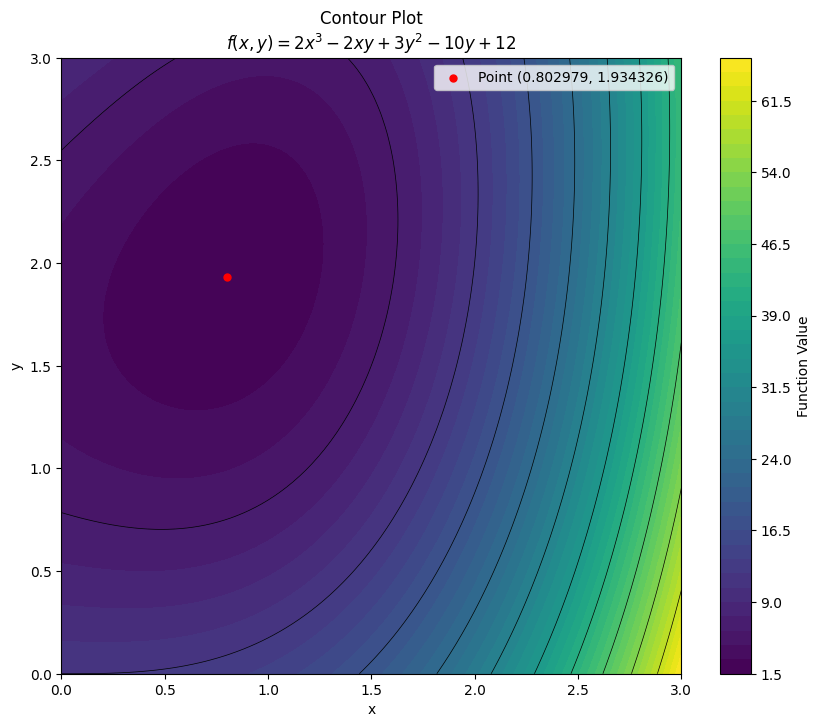

In [7]:
# Generate a denser meshgrid for smoother contours
x = np.linspace(0, 3, 100)  # Increase the number of points
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)

# Evaluate f on the grid
Z = f_func(X, Y)

# Create the contour plot
plt.figure(figsize=(10, 8))
# Add more levels for smoother contours
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
# Add colorbar with a label
plt.colorbar(contour, label='Function Value')
# Overlay contour lines for clarity
plt.contour(X, Y, Z, levels=10, colors='black', linewidths=0.5)

# Highlight the point with a scatter marker
plt.scatter(minimiser[0], minimiser[1], color='red', s=25,
            label=f'Point ({minimiser[0]:.6f}, {minimiser[1]:.6f})')

# Add axis labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Contour Plot\n$f(x, y) = {{{sp.latex(f)}}}$')

# Add a legend for the marked point
plt.legend()
# Show the plot
plt.show()

----
&nbsp;
### Exercise 2

Starting at $(-1.2,1)$, compute the minimiser, to six decimal places, of Rosenbrock's function

$$f(x,y) =  100(y - x^2)^2 + (1 - x)^2$$

using the Newton–Raphson method.

In [8]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# Define the initial point
x0 = [-1.2, 1]

# Define function
f = 100*(y - x**2)**2 + (1 - x)**2
# Lambdify for later
f_func = sp.lambdify([x, y], f, 'numpy')
display(f)

(1 - x)**2 + 100*(-x**2 + y)**2

In [9]:
result = newton_raphson(f, x0=x0, variables=variables,
                               epsilon=0.5e-6, delta=0.5e-6, eta=0.5e-6,
                               verbose=True)
minimiser = result['x_min']
print()
for key, value in result.items():
    print(f"{key} : {value}")

Gradient:


Matrix([
[-400*x*(-x**2 + y) + 2*x - 2],
[           -200*x**2 + 200*y]])


Hessian


Matrix([
[2*(600*x**2 - 200*y + 1), -400*x],
[                  -400*x,    200]])


Iteration 1: x = [-1.1752809   1.38067416], f(x) = 4.731884325266608
Iteration 2: x = [ 0.76311487 -3.17503385], f(x) = 1411.845179309785
Iteration 3: x = [0.76342968 0.58282478], f(x) = 0.05596551683389605
Iteration 4: x = [0.99999531 0.94402732], f(x) = 0.3131890761160045
Iteration 5: x = [0.9999957  0.99999139], f(x) = 1.852739726959435e-11
Iteration 6: x = [1. 1.], f(x) = 3.4326873271107767e-20

x_min : [1. 1.]
iterations : 6
success : True
f_min : 3.4326873271107767e-20
reason : Gradient norm below tolerance


So, to six decimal places the solution is $(1.000000, 1.000000)$.

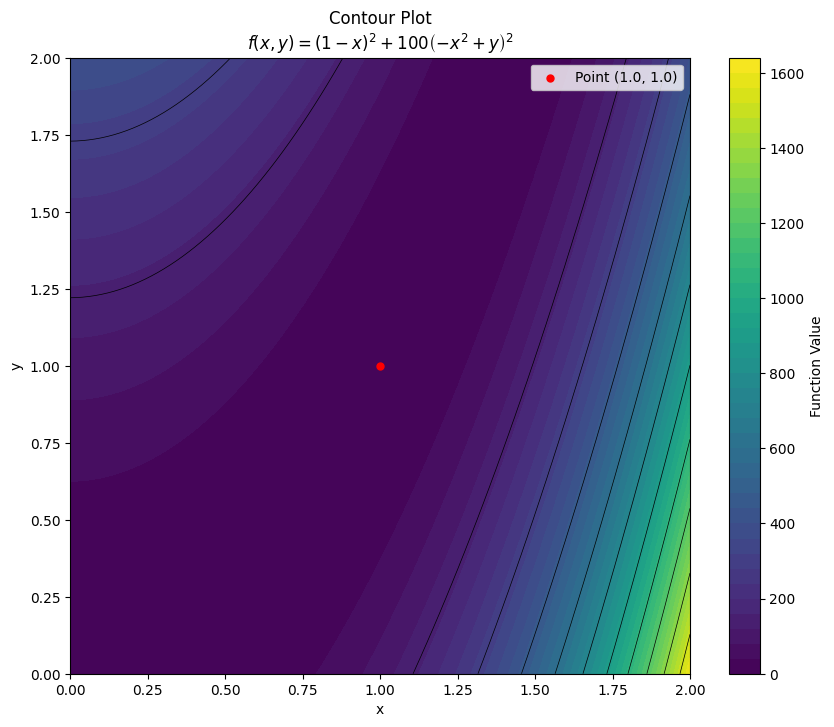

In [10]:
# Generate a denser meshgrid for smoother contours
x = np.linspace(0, 2, 100)  # Increase the number of points
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)

# Evaluate f on the grid
Z = f_func(X, Y)

# Create the contour plot
plt.figure(figsize=(10, 8))
# Add more levels for smoother contours
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
# Add colorbar with a label
plt.colorbar(contour, label='Function Value')
# Overlay contour lines for clarity
plt.contour(X, Y, Z, levels=10, colors='black', linewidths=0.5)

# Highlight the point with a scatter marker
plt.scatter(minimiser[0], minimiser[1], color='red', s=25,
            label=f'Point ({minimiser[0]:.1f}, {minimiser[1]:.1f})')

# Add axis labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Contour Plot\n$f(x, y) = {{{sp.latex(f)}}}$')

# Add a legend for the marked point
plt.legend()
# Show the plot
plt.show()

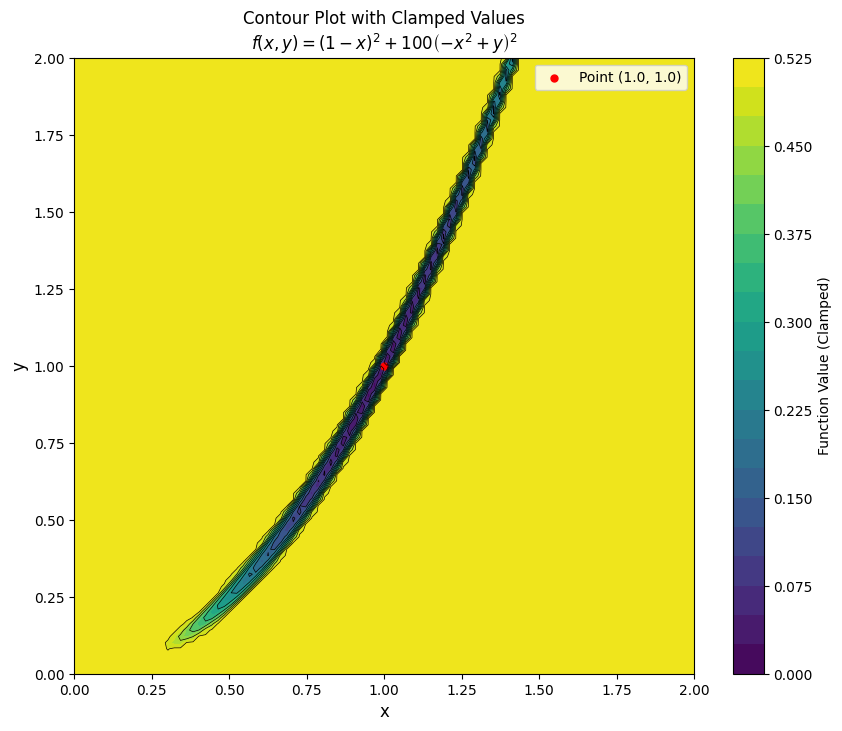

In [11]:
# Generate a denser meshgrid for smoother contours
x = np.linspace(0, 2, 100)  # Increase the number of points
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)

# Evaluate f on the grid
Z = f_func(X, Y)

# Improved contour plot with clamped values
plt.figure(figsize=(10, 8))
# Clamp Z values
clamped_Z = np.minimum(Z, np.min(Z) + 0.5)
# Smoother levels
contour = plt.contourf(X, Y, clamped_Z, levels=20, cmap='viridis')
# Labelled colorbar
plt.colorbar(contour, label='Function Value (Clamped)')

# Overlay contour lines
plt.contour(X, Y, clamped_Z, levels=10, colors='black', linewidths=0.5)

# Highlight the point with a scatter marker
plt.scatter(minimiser[0], minimiser[1], color='red', s=25,
            label=f'Point ({minimiser[0]:.1f}, {minimiser[1]:.1f})')

# Add axis labels and title
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'Contour Plot with Clamped Values\n$f(x, y) = {{{sp.latex(f)}}}$')

# Add a legend for the marked point
plt.legend()
# Show the plot
plt.show()

----

#### Example 3:
The Newton-Raphson method will fail...


Find a local minimum, to six decimal places, of the function

$$f(x,y) = (x^2 - 1)^2 + y^2$$

starting from $(0.1\ 0.0)^T$

In [12]:
# Define the variables
x, y = sp.symbols('x y')
variables = [x, y]

# 3. Pick an initial guess near the saddle point (0,0)
x0 = [0.1, 0.0]  # close enough to the saddle so Hessian is indefinite

# Define function
f = (x**2 - 1)**2 + y**2
# Lambdify for plotting
f_func = sp.lambdify([x, y], f, 'numpy')
display(f)

y**2 + (x**2 - 1)**2

In [13]:
result = newton_raphson(f, x0=x0, variables=variables,
                               epsilon=0.5e-6, delta=0.5e-6, eta=0.5e-6,
                               verbose=True)
minimiser = result['x_min']
print()
for key, value in result.items():
    print(f"{key} : {value}")

Gradient:


Matrix([
[4*x*(x**2 - 1)],
[           2*y]])


Hessian


Matrix([
[4*(3*x**2 - 1), 0],
[             0, 2]])


Matrix is not positive definite. Pivoting will be applied.

x_min : [0.1 0. ]
iterations : 0
success : False
f_min : 0.9801
reason : Hessian not positive definite


----

### `NewtonRaphsonSolver` class

#### Rosenbrock function
Testing the Rosenbrock function
$$f(x,y) =  100(y - x^2)^2 + (1 - x)^2$$

Starting at $(-1.2,1)$, which is standard benchmarking point

In [14]:
%reset -f
import sympy as sp
from Classes.NewtonRaphson import NewtonRaphsonSolver

# Define variables and function
x, y = sp.symbols('x y')
f = 100 * (y - x**2)**2 + (1 - x)**2
x0 = [-1.2, 1]

# Initialize solver
rosenbrock = NewtonRaphsonSolver(f, [x, y], x0)
result = rosenbrock.solve(verbose=True)

# Display result
print()
for key, value in result.items():
    if key != "history":  # Skip history for brevity
        print(f"{key}: {value}")

Iteration 1: x = [-1.1752809   1.38067416], f(x) = 4.731884325266608
Iteration 2: x = [ 0.76311487 -3.17503385], f(x) = 1411.845179309785
Iteration 3: x = [0.76342968 0.58282478], f(x) = 0.05596551683389605
Iteration 4: x = [0.99999531 0.94402732], f(x) = 0.3131890761160045
Iteration 5: x = [0.9999957  0.99999139], f(x) = 1.852739726959435e-11
Iteration 6: x = [1. 1.], f(x) = 3.4326873271107767e-20
Iteration 7: x = [1. 1.], f(x) = 4.89352606221553e-28

x_min: [1. 1.]
iterations: 7
success: True
f_min: 4.89352606221553e-28
reason: Converged within tolerances


In [15]:
print("Hessian:")
display(rosenbrock.hessian)

Hessian:


Matrix([
[2*(600*x**2 - 200*y + 1), -400*x],
[                  -400*x,    200]])

In [16]:
print("Gradient:")
display(rosenbrock.gradient)

Gradient:


Matrix([
[-400*x*(-x**2 + y) + 2*x - 2],
[           -200*x**2 + 200*y]])

-----
&nbsp;
#### Example 2
Use the Newton–Raphson method to find a local minimum of
$$f(x,y)=2x^3 - 2x y + 3y^2 -10y + 12$$
to six decimal places.


In [17]:
%reset -f
import sympy as sp
from Classes.NewtonRaphson import NewtonRaphsonSolver

# Define variables and function
x, y = sp.symbols('x y')
f = 2*x**3 - 2*x*y + 3*y** 2 - 10*y + 12
x0 = [3, 0]

# Initialize solver
solver = NewtonRaphsonSolver(f, [x, y], x0)
result = solver.solve(verbose=True)

# Display result
print()
for key, value in result.items():
    if key != "history":  # Skip history for brevity
        print(f"{key}: {value}")

Iteration 1: x = [1.62264151 2.20754717], f(x) = 5.9249246021883835
Iteration 2: x = [1.01734082 2.00578027], f(x) = 2.036396061991283
Iteration 3: x = [0.82686747 1.94228916], f(x) = 1.813213302581266
Iteration 4: x = [0.80334904 1.93444968], f(x) = 1.8106275324932604
Iteration 5: x = [0.80297921 1.9343264 ], f(x) = 1.8106269187103656
Iteration 6: x = [0.80297911 1.93432637], f(x) = 1.81062691871033

x_min: [0.80297911 1.93432637]
iterations: 6
success: True
f_min: 1.81062691871033
reason: Converged within tolerances


In [18]:
print("Hessian:")
display(solver.hessian)

Hessian:


Matrix([
[12*x, -2],
[  -2,  6]])

In [19]:
print("Gradient:")
display(solver.gradient)

Gradient:


Matrix([
[   6*x**2 - 2*y],
[-2*x + 6*y - 10]])

----